In [1]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

# with h5py.File(f'data_large/Burgers_train_100000_default.h5', 'r') as f:
#     # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
#     traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import hydra
from omegaconf import DictConfig, OmegaConf
from generate_data import evolve
from tqdm import tqdm

hydra.initialize(config_path="cfg_flexible", version_base=None)
cfg = hydra.compose(config_name="config", overrides=["task=NS", "nt=14"])

In [3]:
with h5py.File(cfg.dataset.train_path, 'r') as f:
    # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
    traj = torch.tensor(f['train']['pde'][:1000, :131:10], dtype=torch.float32)
    # traj = torch.tensor(f['train']['pde'][:128, 30:131:5], dtype=torch.float32)

In [4]:
print(traj.shape)

torch.Size([1000, 14, 1, 32, 32])


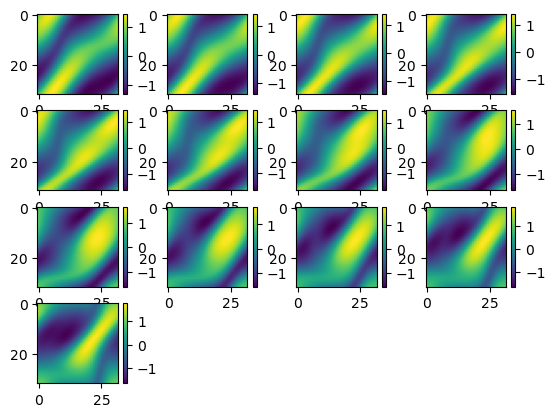

In [5]:
plt.figure()
for i in range(13):
    plt.subplot(4,4,i+1)
    plt.imshow(traj[78,i,0].cpu().numpy())
    plt.colorbar()

torch.Size([14000, 1024])
(14000, 2)


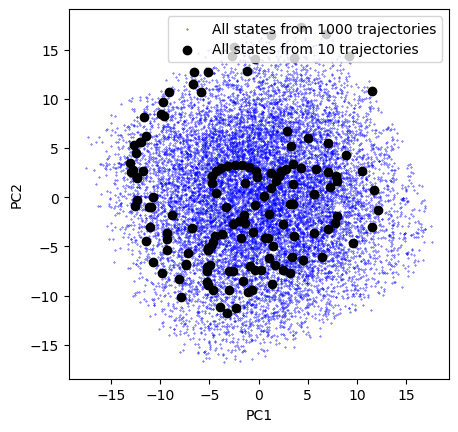

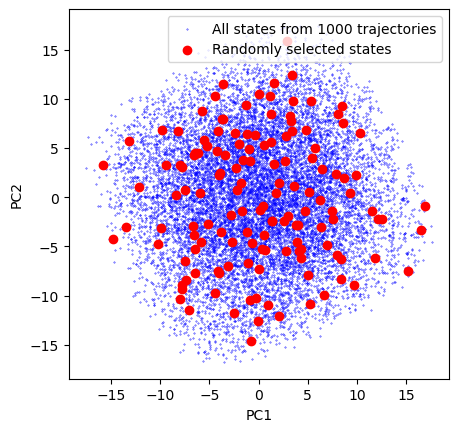

In [6]:
data = traj.flatten(2) # (1000, 131, 1) -> (1000, 131)

selected = torch.zeros(*data.shape[0:2]).bool()
selected[:10, :] = True

selected_scattered = torch.zeros(*data.shape[0:2]).bool()
selected_scattered = selected_scattered.flatten()
selected_scattered[torch.randperm(selected_scattered.shape[0])[:selected.sum()]] = True

data = data.flatten(0,1) # (datasize*nt, nx)
selected = selected.flatten(0,1) # (datasize*nt)a

# perform PCA on data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
print(data.shape)
data_transformed = pca.fit_transform(data)
print(data_transformed.shape)

# plot the first two principal components
# plot selected components in red
# plot selected_scattered components in green
# make the points small
# make the plot square size
plt.figure()
plt.scatter(data_transformed[:,0], data_transformed[:,1], c='b', s=0.1)
plt.scatter(data_transformed[selected,0], data_transformed[selected,1], c='k')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['All states from 1000 trajectories', 'All states from 10 trajectories'])

plt.figure()
plt.scatter(data_transformed[:,0], data_transformed[:,1], c='b', s=0.1)
plt.scatter(data_transformed[selected_scattered,0], data_transformed[selected_scattered,1], c='r')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(['All states from 1000 trajectories', 'Randomly selected states'])


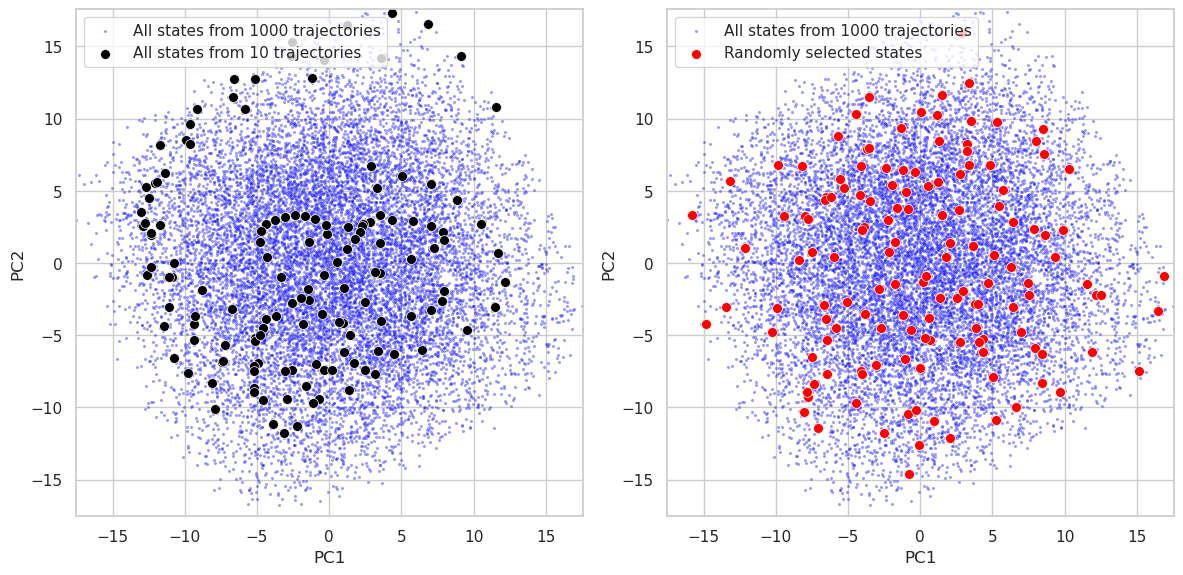

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import torch

# Assuming the previous setup (data preparation and PCA) remains the same
# Scatter plot using seaborn

# Set seaborn style for prettier plots
sns.set(style='whitegrid')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Calculate the limits based on the data (both x and y should have the same limits)
min_limit = min(np.min(data_transformed[:, 0]), np.min(data_transformed[:, 1]))
max_limit = max(np.max(data_transformed[:, 0]), np.max(data_transformed[:, 1]))

# First plot: selected components in black, larger and with different transparency for blue
sns.scatterplot(ax=axes[0], x=data_transformed[:, 0], y=data_transformed[:, 1], color='blue', s=5, alpha=0.4, label='All states from 1000 trajectories')  # smaller blue dots
sns.scatterplot(ax=axes[0], x=data_transformed[selected, 0], y=data_transformed[selected, 1], color='black', s=50, edgecolor='white', linewidth=0.5, label='All states from 10 trajectories')  # larger black dots with white edge
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend()
axes[0].set_xlim(min_limit, max_limit)
axes[0].set_ylim(min_limit, max_limit)

# Second plot: selected_scattered components in red, larger with edge color
sns.scatterplot(ax=axes[1], x=data_transformed[:, 0], y=data_transformed[:, 1], color='blue', s=5, alpha=0.4, label='All states from 1000 trajectories')  # smaller blue dots
sns.scatterplot(ax=axes[1], x=data_transformed[selected_scattered, 0], y=data_transformed[selected_scattered, 1], color='red', s=50, edgecolor='white', linewidth=0.5, label='Randomly selected states')  # larger red dots with white edge
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].legend()
axes[1].set_xlim(min_limit, max_limit)
axes[1].set_ylim(min_limit, max_limit)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
